In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 1. Model Definitions (FiLMDenoiser) ---

class FiLMLayer(nn.Module):
    def __init__(self, num_features, condition_dim):
        super(FiLMLayer, self).__init__()
        # Generate gamma (scale) and beta (shift) from condition
        self.gamma_fc = nn.Linear(condition_dim, num_features)
        self.beta_fc = nn.Linear(condition_dim, num_features)
    
    def forward(self, x, condition):
        # x: (batch, channels, height, width)
        # condition: (batch, condition_dim)
        gamma = self.gamma_fc(condition).unsqueeze(-1).unsqueeze(-1)
        beta = self.beta_fc(condition).unsqueeze(-1).unsqueeze(-1)
        return gamma * x + beta

class FiLMDenoiser(nn.Module):
    def __init__(self, condition_dim=16):
        super(FiLMDenoiser, self).__init__()
        
        # Condition embedding
        self.condition_embed = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, condition_dim)
        )
        
        # Encoder
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.film1 = FiLMLayer(64, condition_dim)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.film2 = FiLMLayer(128, condition_dim)
        
        # Middle
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.film3 = FiLMLayer(256, condition_dim)
        
        # Decoder
        self.conv4 = nn.Conv2d(256, 128, 3, padding=1)
        self.film4 = FiLMLayer(128, condition_dim)
        self.conv5 = nn.Conv2d(128, 64, 3, padding=1)
        self.film5 = FiLMLayer(64, condition_dim)
        
        # Output
        self.conv_out = nn.Conv2d(64, 1, 3, padding=1)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
    def forward(self, x, noise_level):
        condition = self.condition_embed(noise_level.view(-1, 1))
        
        # Encoder
        x1 = self.relu(self.film1(self.conv1(x), condition))  # (B, 64, 28, 28)
        x1_pool = self.pool(x1)                               # (B, 64, 14, 14)
        
        x2 = self.relu(self.film2(self.conv2(x1_pool), condition)) # (B, 128, 14, 14)
        x2_pool = self.pool(x2)                                    # (B, 128, 7, 7)
        
        # Middle
        x3 = self.relu(self.film3(self.conv3(x2_pool), condition)) # (B, 256, 7, 7)
        
        # Decoder (Corrected Logic)
        x4 = self.upsample(x3)              # (B, 256, 14, 14)
        x4 = self.conv4(x4)                 # (B, 128, 14, 14) -> Reduce channels
        x4 = self.relu(self.film4(x4 + x2, condition)) # Add skip connection
        
        x5 = self.upsample(x4)              # (B, 128, 28, 28)
        x5 = self.conv5(x5)                 # (B, 64, 28, 28) -> Reduce channels
        x5 = self.relu(self.film5(x5 + x1, condition)) # Add skip connection
        
        out = torch.sigmoid(self.conv_out(x5))
        return out

# --- 2. Custom Dataset (On-the-fly Noise Generation) ---

class NoisyMNISTDataset(Dataset):
    def __init__(self, mnist_dataset, min_noise=0.1, max_noise=0.5):
        self.mnist_dataset = mnist_dataset
        self.min_noise = min_noise
        self.max_noise = max_noise

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        clean_img, _ = self.mnist_dataset[idx] # Already tensor
        
        # Sample random noise level
        noise_level = np.random.uniform(self.min_noise, self.max_noise)
        
        # Add noise
        noise = torch.randn_like(clean_img) * noise_level
        noisy_img = clean_img + noise
        noisy_img = torch.clamp(noisy_img, 0.0, 1.0)
        
        return noisy_img, clean_img, torch.tensor([noise_level], dtype=torch.float32)

# --- 3. Data Preparation ---

print("Loading MNIST dataset...")
transform = transforms.Compose([transforms.ToTensor()])
full_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_base = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Reduce dataset size to 1/10 (6,000 samples)
subset_size = len(full_train_dataset) // 10
indices = list(range(subset_size))
train_subset = Subset(full_train_dataset, indices)

# Create Datasets & Loaders
train_dataset = NoisyMNISTDataset(train_subset, min_noise=0.1, max_noise=0.5)
test_dataset = NoisyMNISTDataset(test_dataset_base, min_noise=0.1, max_noise=0.5) # Using full test set for eval

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Training samples: {len(train_dataset)} (Reduced from 60,000)")

# --- 4. Training Loop with TQDM ---

model = FiLMDenoiser(condition_dim=16).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
history = {'train_loss': []}

print(f"\nStarting training on {device}...")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    # Wrap train_loader with tqdm for progress bar
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (noisy, clean, noise_level) in progress_bar:
        noisy, clean, noise_level = noisy.to(device), clean.to(device), noise_level.to(device)
        
        # Forward
        output = model(noisy, noise_level)
        loss = criterion(output, clean)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Update progress bar with current loss
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    avg_loss = epoch_loss / len(train_loader)
    history['train_loss'].append(avg_loss)
    # print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.6f}") # tqdm handles display

Loading MNIST dataset...
Training samples: 6000 (Reduced from 60,000)

Starting training on cuda...


Epoch 10/10: 100%|█████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 16.01it/s, loss=0.0063]



Testing model...
Results saved to 'film_denoising_results.png'


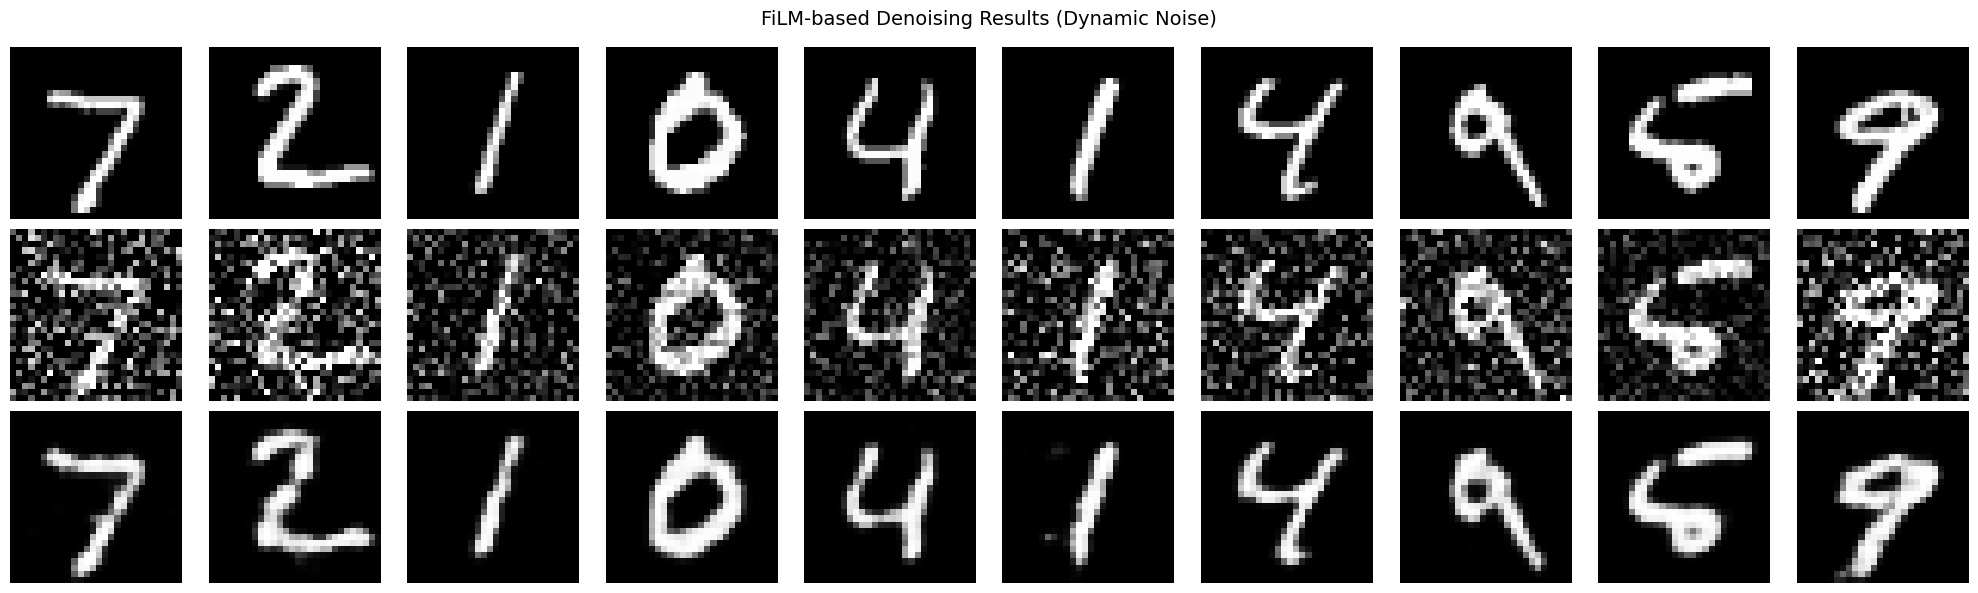

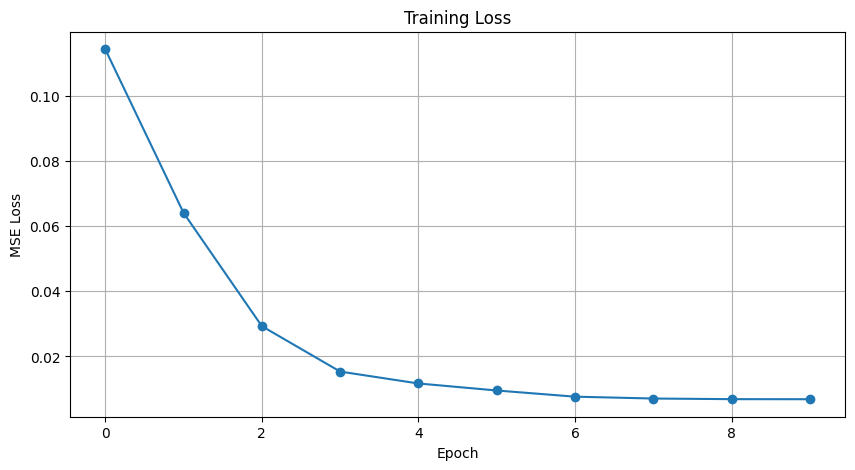

Loss curve saved to 'training_loss.png'


<Figure size 640x480 with 0 Axes>

In [2]:
# --- 5. Evaluation & Visualization ---

print("\nTesting model...")
model.eval()

# Select a few samples for visualization
test_iter = iter(test_loader)
test_noisy, test_clean, test_noise_level = next(test_iter)
test_noisy = test_noisy[:10].to(device)
test_noise_level = test_noise_level[:10].to(device)

with torch.no_grad():
    denoised = model(test_noisy, test_noise_level)
    denoised = denoised.cpu().numpy()
    test_noisy = test_noisy.cpu().numpy()
    test_clean = test_clean[:10].numpy()

# Visualization Plot
fig, axes = plt.subplots(3, 10, figsize=(20, 6))
for i in range(10):
    # Clean
    axes[0, i].imshow(test_clean[i, 0], cmap='gray')
    axes[0, i].axis('off')
    if i == 0: axes[0, i].set_ylabel('Clean', fontsize=12)
    
    # Noisy
    axes[1, i].imshow(test_noisy[i, 0], cmap='gray')
    axes[1, i].axis('off')
    if i == 0: axes[1, i].set_ylabel('Noisy', fontsize=12)
    
    # Denoised
    axes[2, i].imshow(denoised[i, 0], cmap='gray')
    axes[2, i].axis('off')
    if i == 0: axes[2, i].set_ylabel('Denoised', fontsize=12)

plt.suptitle(f'FiLM-based Denoising Results (Dynamic Noise)', fontsize=14)
plt.tight_layout()
plt.savefig('film_denoising_results.png', dpi=150)
print("Results saved to 'film_denoising_results.png'")

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], marker='o', label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()
plt.savefig('training_loss.png')
print("Loss curve saved to 'training_loss.png'")


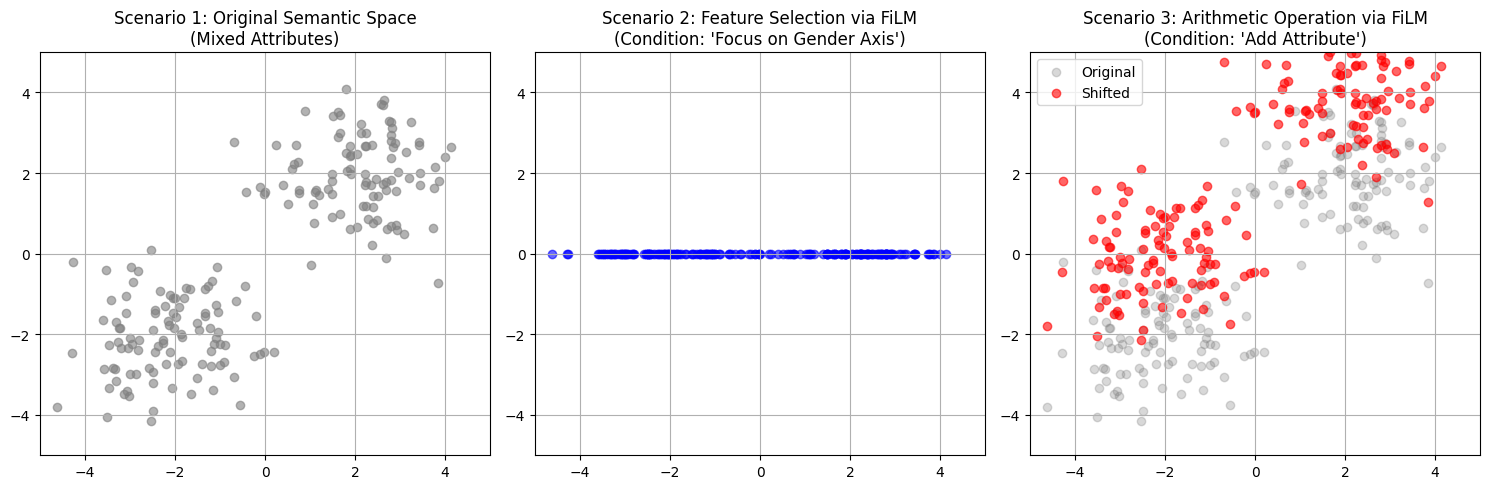

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1. Toy Data Generation (2D Points)
# Simulating word clusters in a semantic space
n_points = 100
cluster1 = np.random.randn(n_points, 2) + np.array([2, 2])
cluster2 = np.random.randn(n_points, 2) + np.array([-2, -2])
data = np.vstack([cluster1, cluster2])
data_tensor = torch.FloatTensor(data)

# 2. Simple FiLM Network for Vector Transformation
class VectorFiLM(nn.Module):
    def __init__(self, input_dim=2, condition_dim=2):
        super().__init__()
        # Generating gamma (scale) and beta (shift) from condition
        self.gamma_fc = nn.Linear(condition_dim, input_dim)
        self.beta_fc = nn.Linear(condition_dim, input_dim)
    
    def forward(self, x, condition):
        # x: (N, 2), condition: (1, 2)
        gamma = self.gamma_fc(condition) # Scale parameter
        beta = self.beta_fc(condition)   # Shift parameter
        
        # FiLM Operation: gamma * x + beta
        # (Standard implementation often uses (1+gamma)*x + beta for stability, 
        # but we use gamma*x for clearer demonstration of scaling)
        return gamma * x + beta

# Model Initialization
# Manually setting weights to demonstrate effects without training
model = VectorFiLM()

# Manually setting weights for demonstration purposes
# Weights for Gamma (Scale): Close to Identity matrix
model.gamma_fc.weight.data = torch.eye(2) 
model.gamma_fc.bias.data = torch.zeros(2)

# Weights for Beta (Shift)
model.beta_fc.weight.data = torch.eye(2)
model.beta_fc.bias.data = torch.zeros(2)

# --- Execution & Visualization ---
plt.figure(figsize=(15, 5))

# Scenario 1: Original Data
plt.subplot(1, 3, 1)
plt.scatter(data[:, 0], data[:, 1], alpha=0.6, c='gray')
plt.title("Scenario 1: Original Semantic Space\n(Mixed Attributes)")
plt.grid(True)
plt.xlim(-5, 5); plt.ylim(-5, 5)

# Scenario 2: Feature Selection (Condition A)
# "Focus on Gender Axis" -> Suppress Y-axis information
# Simulating condition: Gamma=[1, 0], Beta=[0, 0]
# Operation: x*1 + 0, y*0 + 0 -> (x, 0)
with torch.no_grad():
    gamma = torch.tensor([1.0, 0.0])
    beta = torch.tensor([0.0, 0.0])
    # Manually applying FiLM operation for clarity
    transformed_1 = data_tensor * gamma + beta

plt.subplot(1, 3, 2)
plt.scatter(transformed_1[:, 0], transformed_1[:, 1], alpha=0.6, c='blue')
plt.title("Scenario 2: Feature Selection via FiLM\n(Condition: 'Focus on Gender Axis')")
plt.grid(True)
plt.xlim(-5, 5); plt.ylim(-5, 5)

# Scenario 3: Arithmetic Operation (Condition B)
# "Add Femininity" -> Shift along Y-axis
# Simulating condition: Gamma=[1, 1] (Keep scale), Beta=[0, 2] (Shift Y)
# Operation: King -> Queen transition effect
with torch.no_grad():
    gamma = torch.tensor([1.0, 1.0])
    beta = torch.tensor([0.0, 2.0]) # Shift Y-axis by +2
    transformed_2 = data_tensor * gamma + beta

plt.subplot(1, 3, 3)
plt.scatter(data[:, 0], data[:, 1], alpha=0.3, c='gray', label='Original') # Reference
plt.scatter(transformed_2[:, 0], transformed_2[:, 1], alpha=0.6, c='red', label='Shifted')
plt.title("Scenario 3: Arithmetic Operation via FiLM\n(Condition: 'Add Attribute')")
plt.legend()
plt.grid(True)
plt.xlim(-5, 5); plt.ylim(-5, 5)

plt.tight_layout()
plt.show()
